# Compare synapses inhibition types using synaptome simulations

Copyright (c) 2025 Open Brain Institute

Authors: Michael W. Reimann, Aurélien Jaquier

last modified: 08.2025

## Summary

The purpose of this notebook is to display the capability of inhibitory synapses to prevent the neuron from spiking depending on their location.

To do so, this notebook analyses three single neuron synaptome simulation output files.

The first one contains only excitatory synapses activated with a range of frequencies.
The second one contains the same excitatory synapses activated at a fixed frequency, and contains proximal inhibitory synapses activated with a range of frequencies.
The last one contains the same excitatory synapses activated at a fixed frequency, and contains distal inhibitory synapses activated with a range of frequencies.

In [2]:
import pandas
import json
import numpy

from scipy.optimize import minimize
from matplotlib import pyplot as plt

from obi_auth import get_token
from entitysdk.client import Client
from entitysdk.models import SingleNeuronSynaptomeSimulation
from obi_notebook import get_projects
from obi_notebook import get_entities


You will first have to authenticate to the platform. To do that, just click on the link after running the python cell below and follow instructions. Then, you will have to select in the drop-dow menu the project that was used to produce the synaptome simulations.

In [3]:
token = get_token(environment="production", auth_mode="daf")
project_context = get_projects.get_projects(token)

Please open url in a different tab:  https://www.openbraininstitute.org/auth/realms/SBO/device?user_code=FOVC-RCTN


Dropdown(description='Select:', options=(('Single Cell Project', {'id': '50280a36-44b9-45e7-8b7d-db220a203ce5'…

In [11]:
client = Client(environment="production", project_context=project_context, token_manager=token)

Here, put the id of the synaptome simulation you performed with only excitatory synapses, or alternitavely, select one form the drop-down menu after running the cell.

In [12]:
exc_only_id = ""
if not exc_only_id:
    exc_only_id_list = []
    exc_only_id_list = get_entities.get_entities("single-neuron-synaptome-simulation", token, exc_only_id_list,
                                            project_context=project_context,
                                            multi_select=False,
                                            page_size=100)

Output()

Here, put the id of the synaptome simulation you performed with only proximal inhibitory synapses, or alternitavely, select one form the drop-down menu after running the cell.

In [13]:
inh_prox_id = ""
if not inh_prox_id:
    inh_prox_id_list = []
    inh_prox_id_list = get_entities.get_entities("single-neuron-synaptome-simulation", token, inh_prox_id_list,
                                            project_context=project_context,
                                            multi_select=False,
                                            page_size=100)

Output()

Here, put the id of the synaptome simulation you performed with only distal inhibitory synapses, or alternitavely, select one form the drop-down menu after running the cell.

In [14]:
inh_dist_id = ""
if not inh_dist_id:
    inh_dist_id_list = []
    inh_dist_id_list = get_entities.get_entities("single-neuron-synaptome-simulation", token, inh_dist_id_list,
                                            project_context=project_context,
                                            multi_select=False,
                                            page_size=100)

Output()

Finally, input below the frequency used for the excitatory synapses. Once this is down, run the cell below to download the data

In [34]:
freq_e_used = 5 # Frequency of the excitatory synapses used in the simulations

ids = {
    "exc-only": exc_only_id if exc_only_id else exc_only_id_list[0],
    "inh-prox": inh_prox_id if inh_prox_id else inh_prox_id_list[0],
    "inh-dist": inh_dist_id if inh_dist_id else inh_dist_id_list[0],
}

# download the data
simulation_paths = {}
for key, sim_id in ids.items():
    simulation = client.get_entity(
        entity_type=SingleNeuronSynaptomeSimulation,
        entity_id=sim_id,
    )
    asset = client.download_assets(
        simulation,
        output_path="./",  # here you can put a repo for downloading the simulation
    ).one()
    simulation_paths[key] = asset.path

## Read in data

In [35]:
data_keys = ["x", "y"]

def entries_to_df(entries):
    data = []    
    for entry in entries:
        df = pandas.DataFrame(dict([(k, entry.pop(k)) for k in data_keys]))
        for k, v in entry.items():
            df[k] = v
        data.append(df)
    ret = pandas.concat(data, axis=0)
    cols = [_c for _c in ret.columns if _c not in data_keys]
    ret = ret.fillna("_NONE").set_index(cols)
    return ret

def read_list_of_entries(lst):
    data = pandas.concat([entries_to_df(_v) for _v in lst.values()], axis=0)
    return data

def read_sim_config_data(fid):
    cfg = json.load(fid)
    data_out = read_list_of_entries(cfg["simulation"])
    stim_out = entries_to_df(cfg["stimulus"])
    return data_out, stim_out

def read_all_contents(sim_path):
    all_data = []; all_stim = []
    with open(sim_path) as fid:
        data, stim = read_sim_config_data(fid)
        all_data.append(data); all_stim.append(stim)
    all_stim = pandas.concat(all_stim, axis=0, keys=range(len(all_stim)), names=["repetition"])
    all_data = pandas.concat(all_data, axis=0, keys=range(len(all_data)), names=["repetition"])
    return (all_stim, all_data)

contents = dict([
    (k, read_all_contents(sim_path))
    for k, sim_path in simulation_paths.items()
])

## Perform simple spike counting

In [36]:
def simple_spike_counter(stim_rec_tuple):
    _, rec_df = stim_rec_tuple
    # This simple spike counter simply detects crossing 0 mV.
    zero_crossings = (rec_df["y"].values[:-1] < 0) & (rec_df["y"].values[1:] >= 0)
    t_spikes = rec_df["x"].iloc[1:][zero_crossings]
    t_spikes.name = "spike-count"

    return t_spikes.groupby(t_spikes.index.names).count()

spike_counts = dict([
    (k, simple_spike_counter(v))
    for k, v in contents.items()
])

## Focus on conditions of interest and reformat data representation

In [37]:
cols_to_drop = ["type", "name", "recording", "varying_key"]
# cols_to_drop = ["type", "name"]
cols_of_interest = ["amplitude", "freq-e", "freq-i-prox", "freq-i-dist"]

df = spike_counts["exc-only"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-e"})
# df = df.drop(columns=cols_to_drop)
df["freq-i-prox"] = 0
df["freq-i-dist"] = 0
spike_counts["exc-only"] = df

df = spike_counts["inh-prox"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-i-prox"})
df["freq-e"] = freq_e_used
df["freq-i-dist"] = 0
spike_counts["inh-prox"] = df

df = spike_counts["inh-dist"].reset_index()
df = df.drop(columns=cols_to_drop).rename(columns={"frequency": "freq-i-dist"})
df["freq-e"] = freq_e_used
df["freq-i-prox"] = 0
spike_counts["inh-dist"] = df

## Plot the number of spikes in function of the frequency

/var/folders/h5/d6s2xj7533n0n5t1py878_040000gn/T/ipykernel_90937/3358423807.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  plt.plot(spike_count_df_ro[(0, 0, 0)], marker='o', label="Excitation only")


'The black arrow indicates the excitatory frequency used for the second plot.'

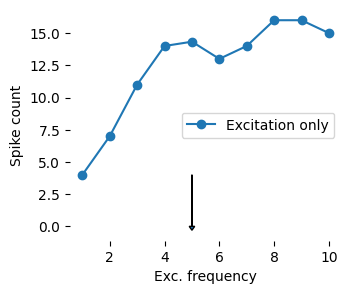

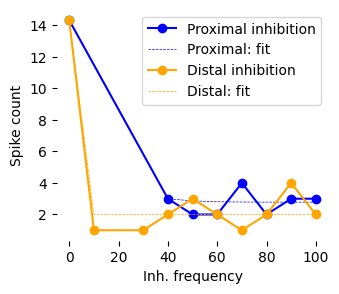

In [38]:
spike_count_df = pandas.concat(list(spike_counts.values()), axis=0)

spike_count_df = spike_count_df.groupby(cols_of_interest)["spike-count"].mean()
spike_count_df_ro = spike_count_df.reorder_levels(["amplitude", "freq-i-prox", "freq-i-dist", "freq-e"])

plt.figure(figsize=(3.5, 3.))
plt.plot(spike_count_df_ro[(0, 0, 0)], marker='o', label="Excitation only")
plt.arrow(freq_e_used, 4, 0, -4, head_width=0.2)
plt.legend()
plt.gca().set_xlabel("Exc. frequency")
plt.gca().set_ylabel("Spike count")
plt.gca().set_frame_on(False)

plt.figure(figsize=(3.5, 3.))

data = spike_count_df[(0, freq_e_used)].unstack("freq-i-dist")[0]
x = data.index.values; y = data.values
plt.plot(x, y, marker='o', label="Proximal inhibition", color="blue")
fit_fun = lambda _param: (y[0] - _param[1]) * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res), color="blue", ls="--", lw=0.5, label="Proximal: fit")

data = spike_count_df[(0, freq_e_used)].unstack("freq-i-prox")[0]
x = data.index.values; y = data.values
plt.plot(x, y, marker='o', label="Distal inhibition", color="orange")
fit_fun = lambda _param: (y[0] - _param[1]) * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res), color="orange", ls="--", lw=0.5, label="Distal: fit")

plt.legend()
plt.gca().set_xlabel("Inh. frequency")
plt.gca().set_ylabel("Spike count")
plt.gca().set_frame_on(False)

display("The black arrow indicates the excitatory frequency used for the second plot.")

In [39]:
data = spike_count_df[(0, freq_e_used)].unstack("freq-i-dist")[0]

## Fit to the inhibitory proximal simulation plot

[  0  40  50  60  70  80  90 100]
[14.33333333  3.          2.          2.          4.          2.
  3.          3.        ]
[16.25089123  3.          2.48499672  2.21502121  2.07349439  1.99930307
  1.96041043  1.94002209]


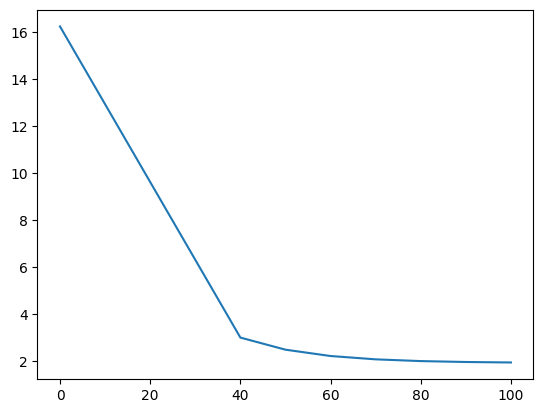

In [40]:
x = data.index.values; y = data.values
fit_fun = lambda _param: y[0] * numpy.exp(-x / _param[0]) + _param[1]
opt_fun = lambda _param: numpy.sum(numpy.abs(fit_fun(_param) - y))
opt_res = minimize(opt_fun, [10.0, 1.0]).x
plt.plot(x, fit_fun(opt_res))
print(x)
print(y)
print(fit_fun(opt_res))
